In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [145]:
class FeatureEngineering():
    def __init__(self):
        self._cabinKnown = False
        self._title = False
        self._familySize = False
        self._isMinor = False
        self._isMinorThresh = 0

    def _familyCategorise(self, s):
        if s>= 4:
            return 'large'
        if s == 0:
            return 'alone'
        if s > 0 and s < 4:
            return 'normal'
    

    def cabinKnown(self, df):
        self._cabinKnown = True
        return pd.Categorical(df['Cabin'].isnull() == False)


    def title(self, df):
        self._title = True
        titles = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

        mr_alias = ['Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer']
        miss_alias = ['Mlle', 'Ms']
        mrs_alias = ['Mme', 'Lady', 'the Countess', 'Dona']

        titles[titles.isin(mr_alias)] = 'Mr'
        titles[titles.isin(miss_alias)] = 'Miss'
        titles[titles.isin(mrs_alias)] = 'Mrs'
        return titles.astype('category')


    def familySize(self, df):
        self._familySize = True
        family = df['Parch'] + df['SibSp']
        return pd.Categorical(list(map(self._familyCategorise, family)), ordered=True)


    def isMinor(self, df, threshold):
        # Try thresholds 14 and 9 to start off with, aim is to balanced 
        # maximising difference between groups while also capturing 
        # most information possible
        self._isMinor = True
        self._isMinorThresh = threshold
        return pd.Categorical(np.digitize(df['Age'], [threshold, 0]))


    def getSummary(self):
        s = "cabinKnown:\t\t{}\ntitle:\t\t\t{}\nfamilySize:\t\t{}\nisMinor (age < {}):\t{}".format(
            self._cabinKnown, self._title, self._familySize, self._isMinorThresh, self._isMinor)
        
        return s

In [111]:
FE = FeatureEngineering()

def engineer_features(df):
    print("Engineering Features...")
    ndf = df.copy()
    ndf['CabinKnown'] = FE.cabinKnown(ndf)
    ndf['Title'] = FE.title(ndf)
    ndf['FamilySize'] = FE.familySize(ndf)
    ndf['IsMinor'] = FE.isMinor(ndf, 14)
    print(''.join(['\t' + ln for ln in FE.getSummary().splitlines(True)]))
    return ndf


def fill_missing(df):
    print("Filling missing values ...")
    ndf = df.copy()
    # Fill missing Fare with median of the corresponding Passenger Class
    missing_fares = ndf[ndf['Fare'].isnull()].index.tolist()

    for fare in missing_fares:
        pclass = ndf.iloc[fare]['Pclass']
        ndf.set_value(fare, 'Fare', ndf[ndf['Pclass'] == pclass]['Fare'].mean())

    print('\tFare:\t\t\tMean of Corresponding Pclass')

    # Fill missing locations with most common
    missing_embarks = ndf[ndf['Embarked'].isnull()].index.tolist()
    mcl = ndf['Embarked'].value_counts().idxmax()
    for eb in missing_embarks:
        ndf.set_value(eb, 'Embarked', mcl)

    print('\tEmbarked:\t\tMode of Embarked')
    return ndf


def transform_features(df):
    print("Transforming features...")
    ndf = df.copy()
    ndf['Fare'] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    print("\tFare:\t\t\tlog")
    return ndf


def prep_data_for_tree_model(df):
    print("Prepping data for model training... no dummies, all cat to codes")
    ndf = pd.DataFrame(df['PassengerId'])
    # Pclass (ordered cat)
    ndf['Pclass'] = pd.to_numeric(df['Pclass'])
    # Sex (binary cat)
    ndf['IsMale'] = df['Sex'].cat.codes
    # Fare (num)
    ndf['Fare'] = df['Fare']
    # Embarked (unordered multilevel cat)
    ndf['Embarked'] = df['Embarked'].cat.codes
    # CabinKnown (binary cat)
    ndf['CabinKnown'] = df['CabinKnown'].cat.codes
    # Title (unordered multilevel cat)
    ndf['Title'] = df['Title'].cat.codes
    # FamilySize (ordered cat)
    ndf['FamilySize'] = df['FamilySize'].cat.codes
    # isMinor (binary cat)
    ndf['IsMinor'] = df['IsMinor'].cat.codes
    return ndf


def prep_data_for_sv_model(df):
    print("Prepping data for scale variant model training...")
    ndf = pd.DataFrame(df['PassengerId'])
    # Pclass (ordered cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Pclass'], prefix='Pclass')], axis=1)
    # Sex (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Sex'], prefix='Sex')], axis=1)
    # Fare (num)
    ndf['Fare'] = df['Fare']
    # Embarked (unordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)
    # CabinKnown (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['CabinKnown'], prefix='CabinKnown')], axis=1)
    # Title (unordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['Title'], prefix='Title')], axis=1)
    # FamilySize (ordered multilevel cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['FamilySize'], prefix='FamilySize')], axis=1)
    # isMinor (binary cat)
    ndf = pd.concat([ndf, pd.get_dummies(df['IsMinor'], prefix='IsMinor')], axis=1)
    return ndf


def coerce_types(df):
    ndf = df.copy()
    ndf.Pclass = ndf.Pclass.astype("category", categories=[1, 2, 3], ordered=True)
    ndf.Sex = ndf.Sex.astype("category")
    ndf.Embarked = ndf.Embarked.astype("category")
    return ndf


def naSummary(df):
    return df.isnull().sum()

In [146]:
train = pd.read_csv('../input/train_pp.csv')
test = pd.read_csv('../input/test_pp.csv')

combine = pd.concat([train.drop('Survived', 1), test])
combine.reset_index(inplace=True, drop=True) 
combine = coerce_types(combine)

combine = engineer_features(combine)
combine = fill_missing(combine)

combine = transform_features(combine)
combine_tree = prep_data_for_tree_model(combine)
combine_svm = prep_data_for_sv_model(combine)

X_train = combine_tree[:len(train)].drop('PassengerId', axis=1)
X_test = combine_tree[len(train):].drop('PassengerId', axis=1)
y_train = train['Survived']

Engineering Features...
	cabinKnown:		True
	title:			True
	familySize:		True
	isMinor (age < 14):	True
Filling missing values ...
	Fare:			Mean of Corresponding Pclass
	Embarked:		Mode of Embarked
Transforming features...
	Fare:			log
Prepping data for model training... no dummies, all cat to codes
Prepping data for scale variant model training...


In [5]:
seed = 7
folds = 10

skf = StratifiedKFold(n_splits=folds)
rfc = RandomForestClassifier(random_state=seed, n_estimators=500, max_depth=6, min_samples_leaf=2, max_features='sqrt', warm_start=True)

rfc_scores = cross_val_score(rfc, X=X_train, y=y_train, cv=skf, n_jobs=-1)

In [6]:
rfc_scores

array([ 0.78888889,  0.85555556,  0.75280899,  0.87640449,  0.87640449,
        0.83146067,  0.82022472,  0.78651685,  0.86516854,  0.82954545])

In [7]:
scores = pd.DataFrame(columns=['Model', 'CV Score'])

pd.DataFrame({'Model': np.repeat('RandomForest', 10), 'Score': rfc_scores})

# for sc in rfc_scores:
#     scores.append(pd.DataFrame(['RandomForest', sc]))
    
# scores

,Model,Score
0,RandomForest,0.788889
1,RandomForest,0.855556
2,RandomForest,0.752809
3,RandomForest,0.876404
4,RandomForest,0.876404
5,RandomForest,0.831461
6,RandomForest,0.820225
7,RandomForest,0.786517
8,RandomForest,0.865169
9,RandomForest,0.829545


In [8]:
seed = 7
folds = 10

skf = StratifiedKFold(n_splits=folds)
scores = pd.DataFrame(columns=['Model', 'CV Score'])

classifiers = {
    'RandomForest': RandomForestClassifier(random_state=seed, n_estimators=500, max_depth=6, min_samples_leaf=2, max_features='sqrt'),
    'AdaBoost': AdaBoostClassifier(random_state = seed, n_estimators=500, learning_rate=0.75),
    'GradientBoosting': GradientBoostingClassifier(random_state=seed, n_estimators=500, max_depth=5, min_samples_leaf=2, verbose=0)
}

print("Scoring...  ", end='')
for c in classifiers:
    print(c, end='  ')
    mdl_scores = cross_val_score(classifiers[c], X=X_train, y=y_train, cv=skf, n_jobs=-1)
    scores = scores.append(pd.DataFrame({'Model': np.repeat(c, folds), 'CV Score': mdl_scores}))

Scoring...  RandomForest  AdaBoost  GradientBoosting  

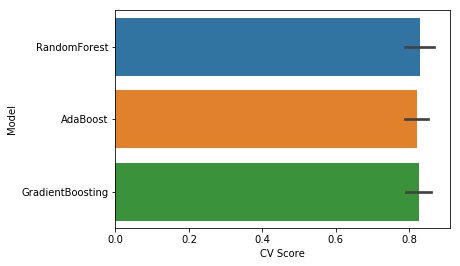

In [9]:
%matplotlib inline
p = sns.barplot(x='CV Score', y='Model', ci="sd", data=scores)

In [149]:
# RFC Tuning

rfc = RandomForestClassifier()

rfc_params = {
    "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "warm_start": [False],
    "n_estimators": [500],
    "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "random_state": [7]
}

gsRFC = GridSearchCV(rfc, param_grid=rfc_params, cv=skf, n_jobs=-1, verbose=1)
gsRFC.fit(X_train, y_train)

Fitting 10 folds for each of 729 candidates, totalling 7290 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 7290 out of 7290 | elapsed: 24.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'warm_start': [False], 'n_estimators': [500], 'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'random_state': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [152]:
bestRFC = gsRFC.best_estimator_
gsRFC.best_params_

{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 500,
 'random_state': 7,
 'warm_start': False}

In [153]:
rfc2_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': bestRFC.predict(X_test)})
rfc2_submit.to_csv("../output/rfc2_submission_kg_.csv", index=False)

In [173]:
test[rfc_submit['Survived'] != rfc2_submit['Survived']]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",female,35.0,1,2,W./C. 6607,23.4500,NaN,S
34,926,1,"Mock, Mr. Philipp Edmund",male,30.0,1,0,13236,57.7500,C78,C
98,990,3,"Braf, Miss. Elin Ester Maria",female,20.0,0,0,347471,7.8542,NaN,S
157,1049,3,"Lundin, Miss. Olga Elida",female,23.0,0,0,347469,7.8542,NaN,S
177,1069,1,"Stengel, Mr. Charles Emil Henry",male,54.0,1,0,11778,55.4417,C116,C
234,1126,1,"Cumings, Mr. John Bradley",male,39.0,1,0,PC 17599,71.2833,C85,C
236,1128,1,"Warren, Mr. Frank Manley",male,64.0,1,0,110813,75.2500,D37,C
249,1141,3,"Khalil, Mrs. Betros (Zahie Maria"" Elias)""",female,20.0,1,0,2660,14.4542,NaN,C


In [175]:
rfc_submit[rfc_submit['Survived'] != rfc2_submit['Survived']]

,PassengerId,Survived
33,925,0
34,926,1
98,990,0
157,1049,0
177,1069,1
234,1126,1
236,1128,1
249,1141,0


In [28]:
# GradientBoost Tuning
gbc = GradientBoostingClassifier()

gbc_params = {
    "loss": ['deviance'],
    "learning_rate": [0.2, 0.1, 0.05, 0.01],
    "n_estimators": [100, 200, 500],
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [2, 4, 6, 8, 10],
    "min_samples_split": [2, 4, 6, 8, 10],
    "random_state": [7]
}

gsGBC = GridSearchCV(gbc, param_grid=gbc_params, cv=skf, n_jobs=-1, verbose=1)
gsGBC.fit(X_train, y_train)

Fitting 10 folds for each of 1500 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 833 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 1183 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 1633 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2183 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2833 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3583 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4433 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5383 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 6433 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 7583 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 8833 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 10183 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 11633 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 13183 tasks      | elapsed: 

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.2, 0.1, 0.05, 0.01], 'n_estimators': [100, 200, 500], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6, 8, 10], 'random_state': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
bestGBC = gsGBC.best_estimator_
gsGBC.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 7}

In [49]:
gbc_submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': bestGBC.predict(X_test)})
gbc_submit.to_csv("../output/gbc_submission_kg_.csv", index=False)

In [48]:
(gbc_submit['Survived'] == rfc_submit['Survived']).value_counts()

True     390
False     28
Name: Survived, dtype: int64